In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
trainlabels = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")

In [3]:
display(trainlabels)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [4]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 693.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.2/379.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.2 MB/s eta 0:00:0000:0100:01


In [5]:
import py7zr
temp_path = '/kaggle/temp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
train_file_path = '/kaggle/input/cifar-10/train.7z'
archive = py7zr.SevenZipFile(train_file_path, mode='r')
archive.extractall(path=temp_path)
archive.close()

In [7]:
train_data = os.path.join(temp_path,'train')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

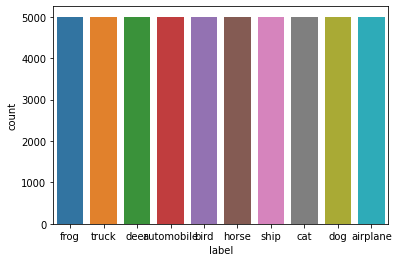

In [8]:
sns.countplot(trainlabels['label'])

In [9]:
def append_ext(fn):
    return "/kaggle/temp/train/"+str(fn)+'.png'

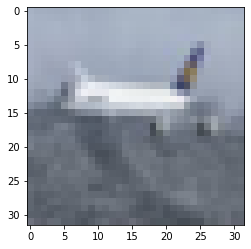

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/kaggle/temp/train/200.png')
imgplot = plt.imshow(img)
plt.show()

In [14]:
trainlabels['path'] = trainlabels['id']
trainlabels['path'] = trainlabels['path'].apply(append_ext)
datagen=ImageDataGenerator(rotation_range=15,width_shift_range=4,height_shift_range=4, validation_split=0.3, rescale=1./255.)
bs=256

In [15]:
trainlabels.head()

,id,label,path
0,1,frog,/kaggle/temp/train/1.png
1,2,truck,/kaggle/temp/train/2.png
2,3,truck,/kaggle/temp/train/3.png
3,4,deer,/kaggle/temp/train/4.png
4,5,automobile,/kaggle/temp/train/5.png


In [16]:
train_generator=datagen.flow_from_dataframe(
                        dataframe=trainlabels,
                        x_col="path",
                        y_col="label",
                        batch_size=bs,
                        seed=42,
                        subset = 'training',
                        shuffle=True,
                        validation_plit = 0.3,
                        class_mode="categorical",
                        target_size =  (32,32))

validation_generator=datagen.flow_from_dataframe(
                        dataframe=trainlabels,
                        x_col="path",
                        y_col="label",
                        batch_size=bs,
                        seed=42,
                        subset = 'validation',
                        shuffle=True,
                        validation_plit = 0.3,
                        class_mode="categorical",
                        target_size =  (32,32))


Found 35000 validated image filenames belonging to 10 classes.
Found 15000 validated image filenames belonging to 10 classes.


In [17]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10))

2022-10-03 18:21:54.015937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 18:21:54.120853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 18:21:54.121713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 18:21:54.123464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [20]:
def create_callback_list(model_directory_name):
    # Create checkpoint to save the best Model
    chk = ModelCheckpoint(model_directory_name,
                          monitor="val_loss",
                          verbose=1,
                          save_best_only=True,
                          save_weights_only=False,
                          mode='min',
                          period=1)
    # Reduce the learning rate with by 0.5 (factor param) if the val_loss is not reduced for 20 epochs (patience)
    rlr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5,
                            patience=10,
                            verbose=1,
                            mode='auto',
                            min_delta=0,
                            cooldown=10,
                            min_lr=0.00000001)
    # Stop learning if the val_loss is not reduced for 250 epochs (patience param)
    stp = EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=20,
                        verbose=1,
                        mode='auto')

    # Return the callback list
    return [chk, stp]
callbacks = create_callback_list('kaggle/temp')

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.samples // bs,
                    callbacks = callbacks,
                    epochs=10, 
                    batch_size = bs)

2022-10-03 18:22:18.346680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-10-03 18:22:20.218703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


137/137 [==============================] - 53s 330ms/step - loss: 5.9797 - accuracy: 0.1193 - val_loss: 4.8927 - val_accuracy: 0.1075

Epoch 00001: val_loss improved from inf to 4.89269, saving model to kaggle/temp


2022-10-03 18:23:11.948678: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/10
137/137 [==============================] - 43s 316ms/step - loss: 3.3152 - accuracy: 0.0962 - val_loss: 3.7475 - val_accuracy: 0.1292

Epoch 00002: val_loss improved from 4.89269 to 3.74749, saving model to kaggle/temp
Epoch 3/10
137/137 [==============================] - 52s 378ms/step - loss: 2.8606 - accuracy: 0.1007 - val_loss: 2.7435 - val_accuracy: 0.1392

Epoch 00003: val_loss improved from 3.74749 to 2.74346, saving model to kaggle/temp
Epoch 4/10
137/137 [==============================] - 44s 322ms/step - loss: 2.7263 - accuracy: 0.1127 - val_loss: 2.7212 - val_accuracy: 0.1253

Epoch 00004: val_loss improved from 2.74346 to 2.72125, saving model to kaggle/temp
Epoch 5/10
137/137 [==============================] - 44s 322ms/step - loss: 2.6843 - accuracy: 0.1167 - val_loss: 2.5537 - val_accuracy: 0.1241

Epoch 00005: val_loss improved from 2.72125 to 2.55368, saving model to kaggle/temp
Epoch 6/10
137/137 [==============================] - 52s 380ms/step - loss: 2.5

# Sample submission

In [22]:
import shutil
from py7zr import unpack_7zarchive
shutil.register_unpack_format('7zip',['.7z'],unpack_7zarchive)
shutil.unpack_archive('/kaggle/input/cifar-10/test.7z','/kaggle/temp/test')
shutil.unregister_unpack_format('7zip')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [23]:
test_gen = test_datagen.flow_from_directory(directory='/kaggle/temp/test',
                                            target_size=(32,32),
                                            batch_size=bs,
                                            class_mode=None,
                                            shuffle=False)

Found 300000 images belonging to 1 classes.


In [24]:
test_gen.reset()
predictions_vecs = model.predict(test_gen)

predictions_final = np.argmax(predictions_vecs, axis=1)

In [25]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(cifar10_classes)
predicted_classes=np.empty(shape=300000,dtype=np.dtype('U20'))

ind=0
for i in predictions_final.tolist():
    predicted_classes[ind]=cifar10_classes[i]
    ind=ind+1
    
filenames_wo_ext = []
for fname in test_gen.filenames:
    filenames_wo_ext.append(int(fname.split(sep="/")[1].split(sep=".")[0])-1)

predicted_classes_final = np.empty(shape=300000,dtype=np.dtype('U20'))
predicted_classes_final[filenames_wo_ext]=predicted_classes

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [26]:
sub = pd.read_csv('../input/cifar-10/sampleSubmission.csv',header='infer')
sub.info()

sub['label'] = predicted_classes_final
sub.to_csv('submission.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   label   300000 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [29]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [27]:
sub

,id,label
0,1,airplane
1,2,ship
2,3,deer
3,4,ship
4,5,frog
...,...,...
299995,299996,truck
299996,299997,deer
299997,299998,ship
299998,299999,truck
